In [1]:
# Import libraries

from cil.framework import  AcquisitionGeometry

from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise

import matplotlib.pyplot as plt

import numpy as np

In [7]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)

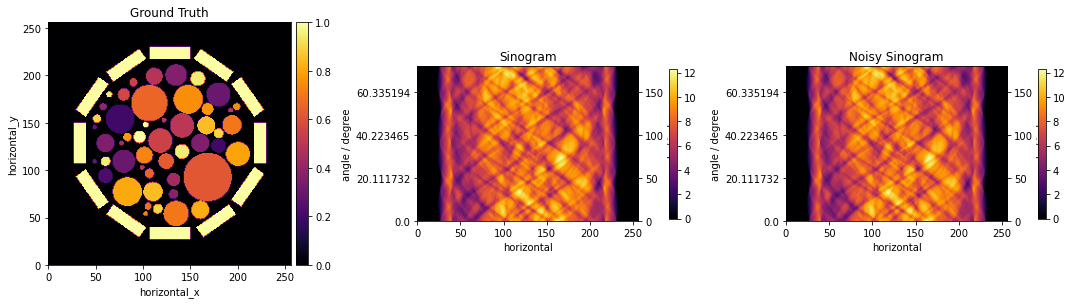

In [12]:
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'cpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
# noisy_sino.fill(n1 + sino.array)
# noisy_sino.array[noisy_sino.array<0]=0
noisy_sino.fill(sino.array)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')


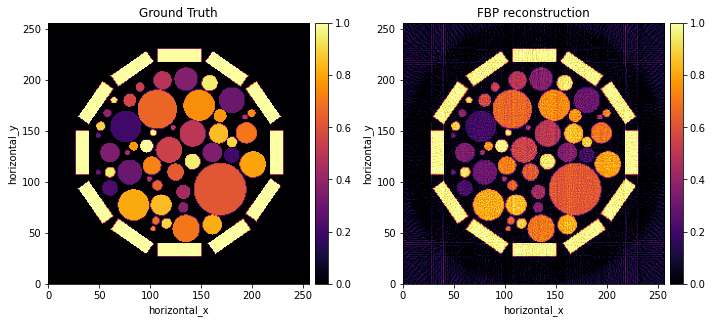

In [16]:
# Setup and run the FBP algorithm
fbp_recon = FBP(ig, ag,  device = 'cpu')(noisy_sino)

# Show reconstructions
show2D([phantom, fbp_recon], 
       title = ['Ground Truth','FBP reconstruction'], 
       cmap = 'inferno', fix_range=(0,1.), size=(10,10))

# General Approximate Gradient Function class

In [41]:
from cil.optimisation.algorithms import Algorithm
from cil.processors import Slicer
from cil.optimisation.functions import LeastSquares

class ApproximateGradientFunction(object):
    
    
    
    # name suggestions: CustomGradientFunction, 
    #                   A name with the subsets word
    #     

    
    def __init__(self, function, **kwargs):

        self.function = function
        self.num_subsets = self.function.length
        
    def __call__(self, x):

        s = 0
        for i in range(self.num_subsets):
            s += self.function[i](x)
        return s    

    def _full_gradient(self, x, out=None):

        s = 0
        for i in range(self.num_subsets):
            s += self.function[i].gradient(x)
        return s                
    
    def gradient(self, x, out=None):
        """        
            maybe calls _approx_grad inside        
        """
        raise NotImplemented


    def subset_gradient(self, x, subset_num,  out=None):

        return self.function[subset_num].gradient(x)


    def next_subset(self):

        raise NotImplemented

# SAGA Function class

In [35]:
class SAGA_Function(ApproximateGradientFunction):

    def __init__(self, function):

        self.initialise_gradients = False
        
        # maybe this bound on the Lips constant not optimal
        self.L = function.L
        
        
        
        super(SAGA_Function, self).__init__(function)

    def gradient(self, x, out=None):

        if not self.initialise_gradients:
            self.memory_init(x) 

        # random choice of subset
        self.next_subset()

        subset_grad_old = self.subset_gradients[self.subset_num]
        full_grad_old = self.full_gradient

        # This is step 6 of the SAGA algo, and we multiply by the num_subsets to take care the (1/n) weight
        # step below to be optimised --> multiplication
        subset_grad = self.num_subsets * self.function[self.subset_num].gradient(x)

        tmp = subset_grad - subset_grad_old + full_grad_old

        
        self.memory_update(subset_grad)
     
        return tmp


    def memory_update(self, subset_grad):

        # step below to be optimised --> div
        self.full_gradient += (subset_grad - self.subset_gradients[self.subset_num])/self.num_subsets
        self.subset_gradients[self.subset_num] = subset_grad 
        

    def next_subset(self):
        
        self.subset_num = int(np.random.choice(self.num_subsets))

    def memory_init(self, x):
        
        """        
            initialize subset gradient (v_i_s) and full gradient (g_bar) and store in memory.

        """


        self.initialise_gradients = True

        # this is the memory init = subsets_gradients + full gradient
        self.subset_gradients = [x.copy()*0.0 for _ in range(self.num_subsets)]
        self.full_gradient = x.copy()*0.0

# Gradient Descent (step) as Class

In [36]:
                                            
class GradientDescent(Algorithm):
    """
        Gradient Descent w/o Armijo rule
    """

    def  __init__(self, initial=None, objective_function=None, step_size=1, **kwargs):

        super(GradientDescent, self).__init__(**kwargs)

        self.set_up(initial=initial, objective_function=objective_function, step_size=step_size)



    def set_up(self, initial, objective_function, step_size):

        self.x = initial.copy()
        self.objective_function = objective_function
        self.x_update = initial.copy()
        self.step_size = step_size
        self.update_objective()
        self.update_step_size = False        
        self.configured = True
        

    def update(self):
        '''Single iteration'''
        
        self.x_update = self.objective_function.gradient(self.x)
        
        self.x_update *= -self.step_size
        self.x += self.x_update

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

# Setup subset framework from SAGA

In [37]:
# Define number of subsets
n_subsets = 10

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = LeastSquares(Ai, b = data_subset)
    f_subsets.append(fi)


# Define F and K
F = BlockFunction(*f_subsets)

# Run SAGA 

In [38]:
F_saga = SAGA_Function(F)

num_epochs = 200

initial = ig.allocate(0)
gd = GradientDescent(initial=initial, objective_function=F_saga,
                     step_size=0.0005, update_objective_interval=n_subsets, 
                     max_iteration=10000)
gd.run(num_epochs * n_subsets, verbose=0)

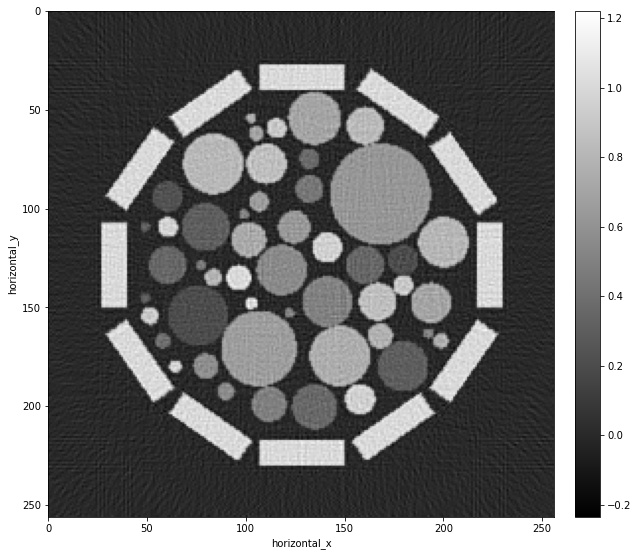

In [39]:
#%%
show2D(gd.solution, origin="upper")

# Run simple Gradient Descent

In [40]:
f_gd = LeastSquares(A, noisy_sino)

In [42]:
initial = ig.allocate(0)
gd_no_sub = GradientDescent(initial=initial, objective_function=f_gd,
                     step_size=0.0009, update_objective_interval=1, 
                     max_iteration=1000)
gd_no_sub.run(num_epochs, verbose=0)

# Run FISTA-SAGA

In [ ]:
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import ZeroFunction, IndicatorBox

In [ ]:
# g = IndicatorBox(lower=0)
g = ZeroFunction()
initial = ig.allocate(0)

In [ ]:
import numpy

def new_update(self):
    
    self.t_old = self.t
    self.u = self.f.gradient(self.y)
    self.u.__imul__( -self.invL )
    self.u.__iadd__( self.y )

    self.g.proximal(self.u, self.invL, out=self.x)

    self.t = 0.5*(1 + numpy.sqrt(1 + 4*(self.t_old**2)))

    self.x.subtract(self.x_old, out=self.y)
    self.y.axpby(((self.t_old-1)/self.t), 1, self.x, out=self.y)

    self.x_old.fill(self.x)

FISTA.update = new_update        

In [ ]:
# FISTA + SAGA no proof of convergence, change the step-size(Lip cons)
# might be solved once we correct the scaling factor in SAGA
# proof of convergence for a FISTA-type modified algorithm
# in Accelerating variance-reduced stochastic gradient methods 
# Derek Driggs, Matthias J. Ehrhardt & Carola-Bibiane Schönlieb 2020



F_saga = SAGA_Function(F) 
F_saga.L *= n_subsets

fista = FISTA(initial = initial, f = F_saga, g = g, 
              max_iteration=10000, update_objective_interval=n_subsets)
fista.run(num_epochs*n_subsets, verbose=0)

FISTA setting up
FISTA configured


### Compare algorithms

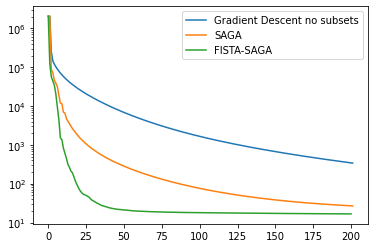

In [ ]:
plt.figure()
plt.semilogy(gd_no_sub.objective, label="Gradient Descent no subsets")
plt.semilogy(gd.objective, label="SAGA")
plt.semilogy(fista.objective, label="FISTA-SAGA")
plt.legend()
plt.show()

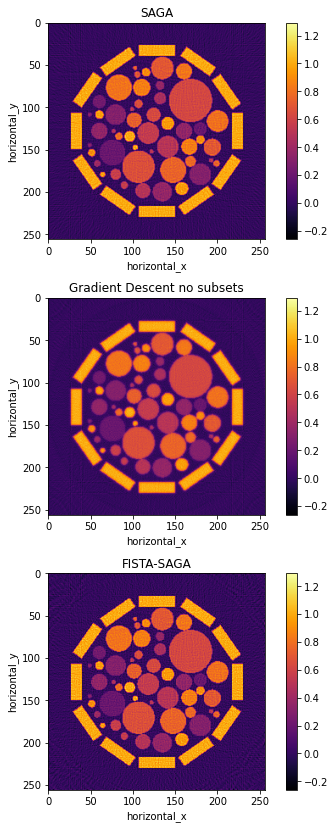

In [ ]:
#%%
show2D([gd.solution,gd_no_sub.solution, fista.solution], 
       origin="upper", 
       title=['SAGA',"Gradient Descent no subsets","FISTA-SAGA"],
       fix_range=True, num_cols=1,
       cmap='inferno')